# NNs in an FRTB Framework

## Notebook Setup

In [1]:
# import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle  
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
# from sklearn.metrics import r2_score
# from scipy.stats import spearmanr
# from scipy.stats import ks_2samp 


from IPython.display import clear_output

from numpy.linalg import cholesky

In [2]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [3]:
# !rm -r {'PHD_Code'}
# !git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code/CODE')

clear_output()

In [4]:
tf.keras.backend.set_floatx('float64')

In [5]:
# PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/DATA/"
# PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/FIGS/"
# PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_definitive/MODELS/"

PATH_DATA = "DATA/"
PATH_FIGS = "FIGS/"
PATH_MODELS = "MODELS_TEST/"

In [6]:
import Option_formulas
import Miscellanea
import Deep_learning_models
import ModelHandlers

In [7]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

## Load Historical Data

In [8]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')

display(hist_data.head(3))
display(hist_data.tail(3))


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2010-01-01,7.526,37.458,125.0310,23.275,41.67,35.088
2010-01-04,7.643,37.428,126.5115,23.198,42.85,34.045
2010-01-05,7.656,38.004,124.9832,23.318,43.68,33.323


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2022-12-06,142.91,34.215,147.50,24.998,131.59,29.305
2022-12-07,140.94,34.771,147.27,25.134,131.50,29.658
2022-12-08,140.94,34.771,147.27,25.134,131.50,29.658


## Computation of 1d and 10d schocks

In [9]:
risk_horizon = 10
hist_data_length = 250

hist_schocks = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns) 

hist_schocks = hist_schocks.iloc[-hist_data_length:]

hist_schocks_daily = pd.DataFrame(data = np.log(hist_data.iloc[1:].values/ hist_data.iloc[0:-1].values),
                            index =  hist_data.index[1:], columns = hist_data.columns) 

hist_schocks_daily = hist_schocks_daily.iloc[-hist_data_length:]


### Plot historical schocks. 10 days

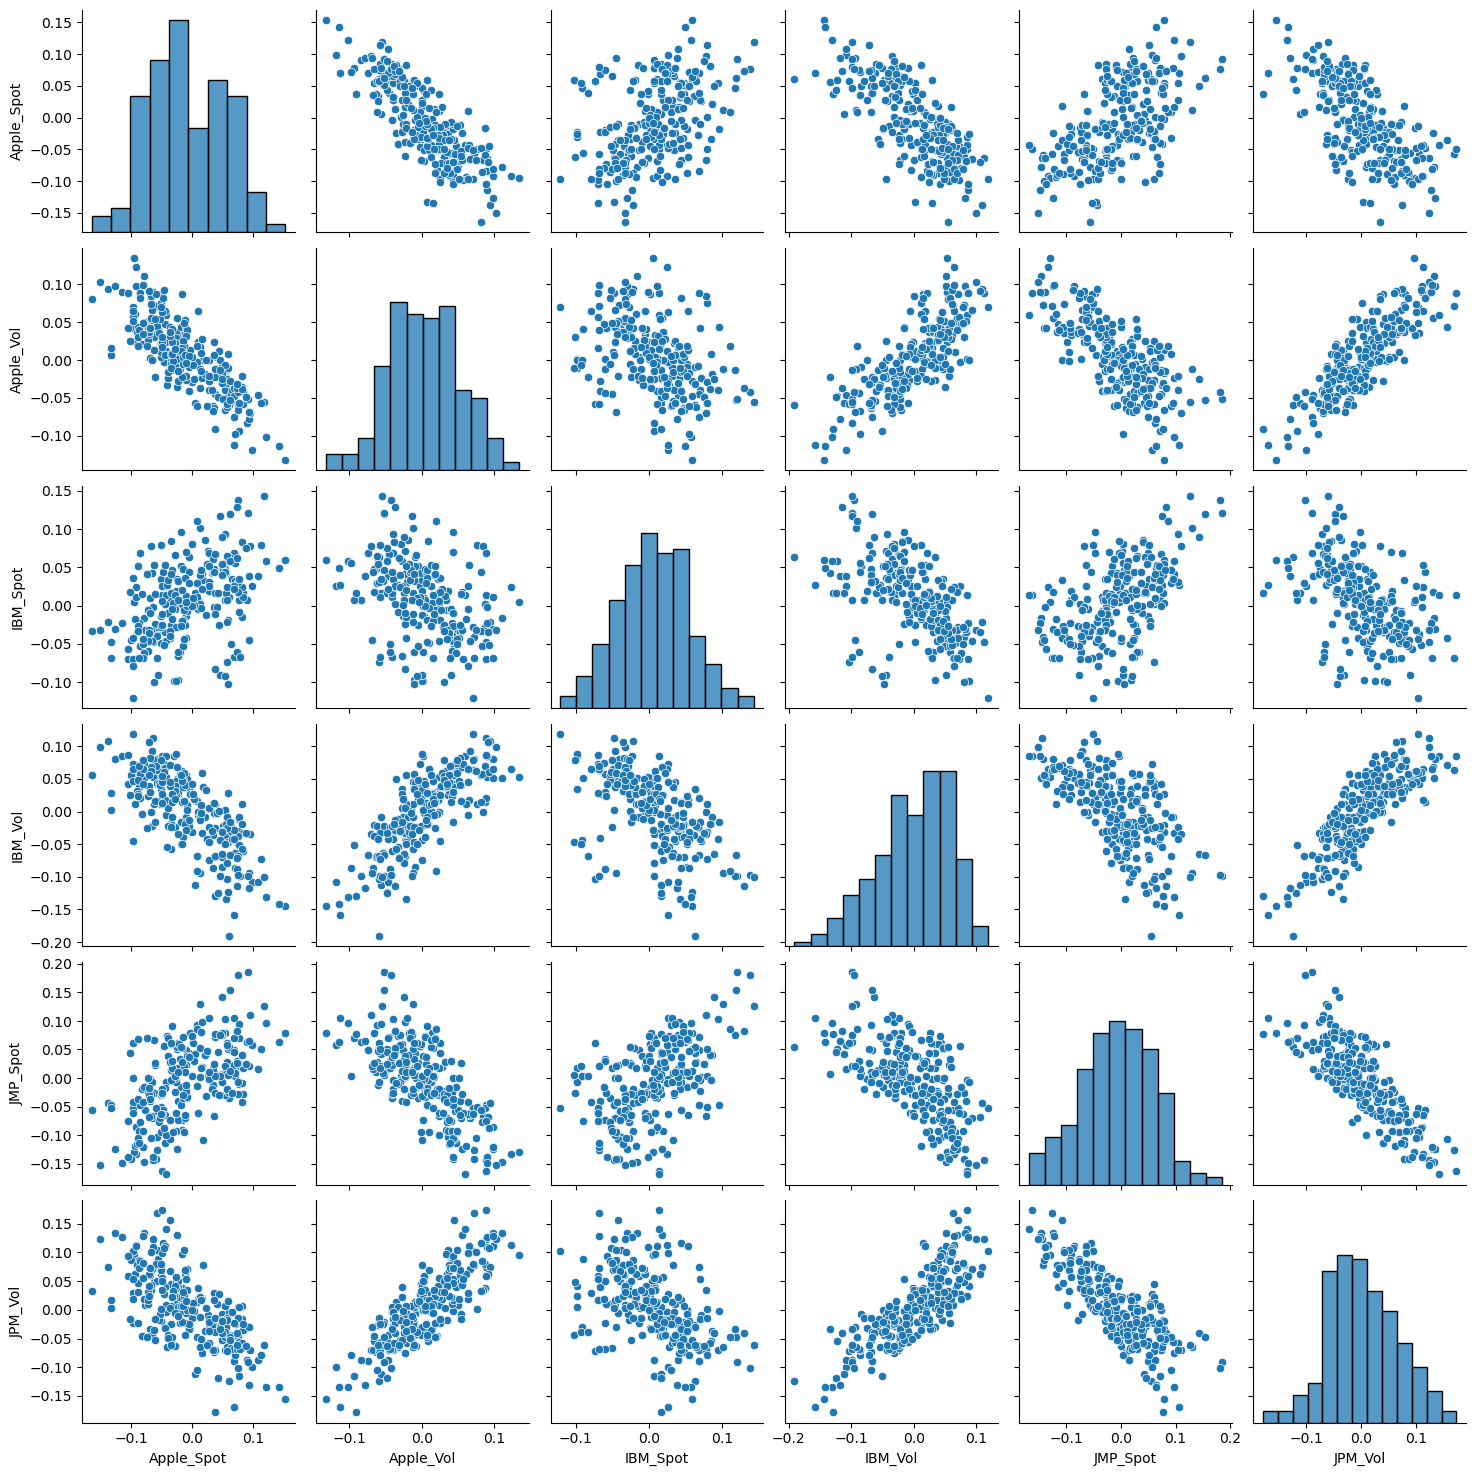

In [10]:
# sns.pairplot(hist_schocks_daily);
sns.pairplot(hist_schocks);


plt.savefig(PATH_FIGS + 'histdata_10d.pdf')

### Plot historical schocks. 1d / 10d

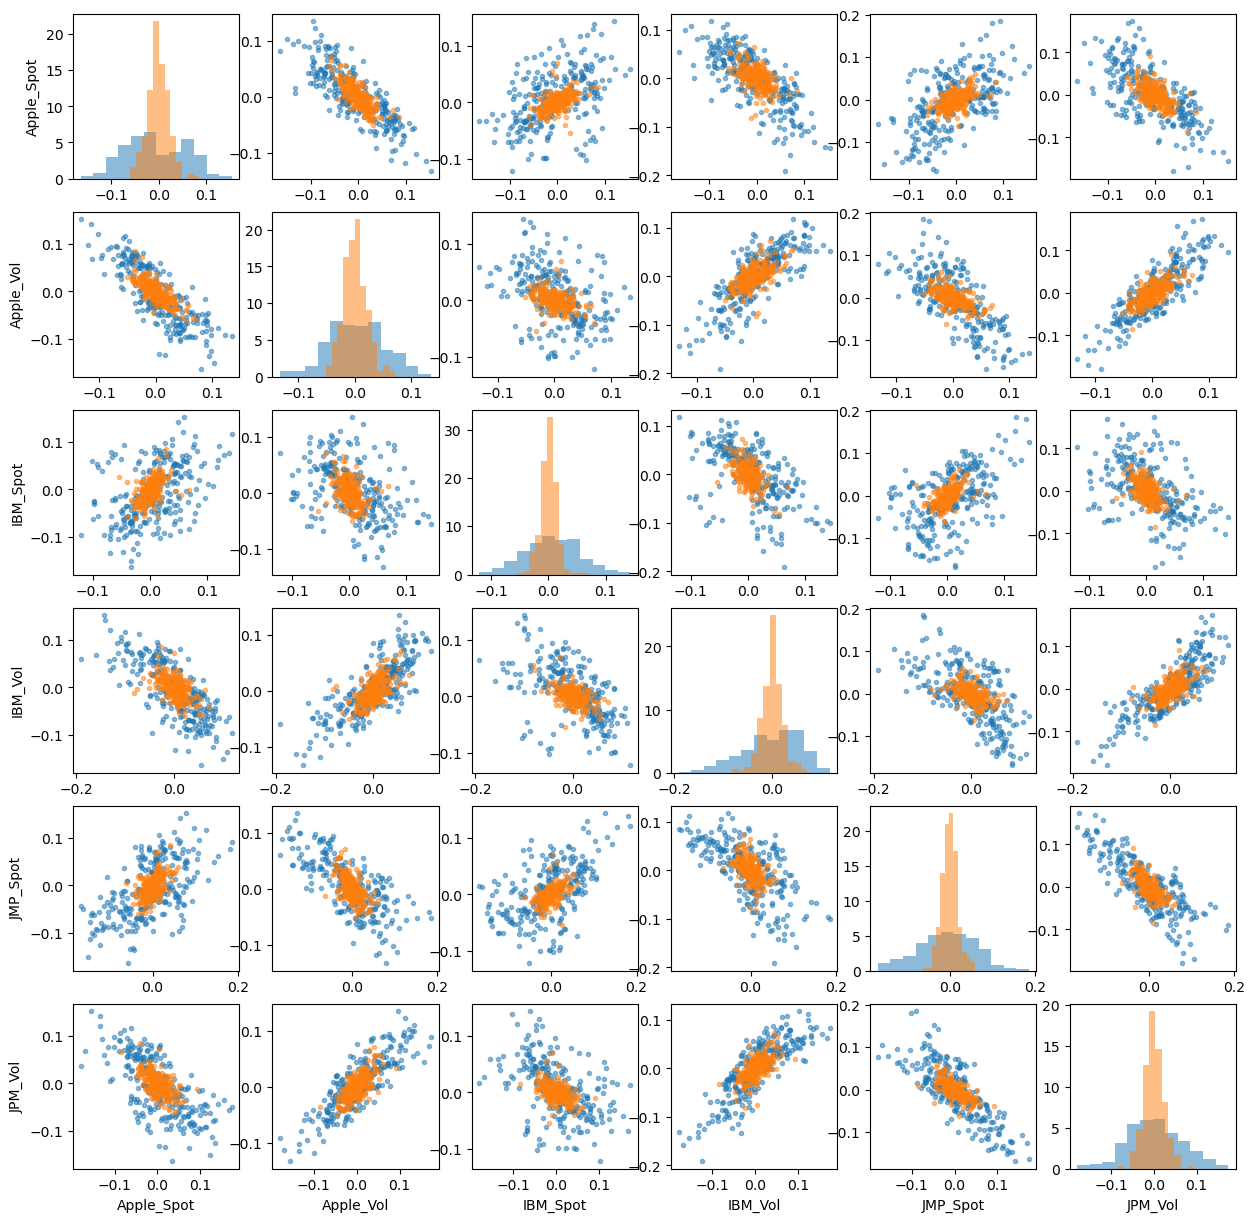

In [11]:
Miscellanea.plot_schocks(6,[hist_schocks.values,hist_schocks_daily.values],hist_schocks.columns,12)  

plt.savefig(PATH_FIGS + 'histdata_1d_10d.pdf')

### Fit a Gaussian Mixture to 10d data

In [12]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components= 6, random_state=1234)

GM.fit(hist_schocks)

GaussianMixture(n_components=6, random_state=1234)

### Plot synthetic data + real data

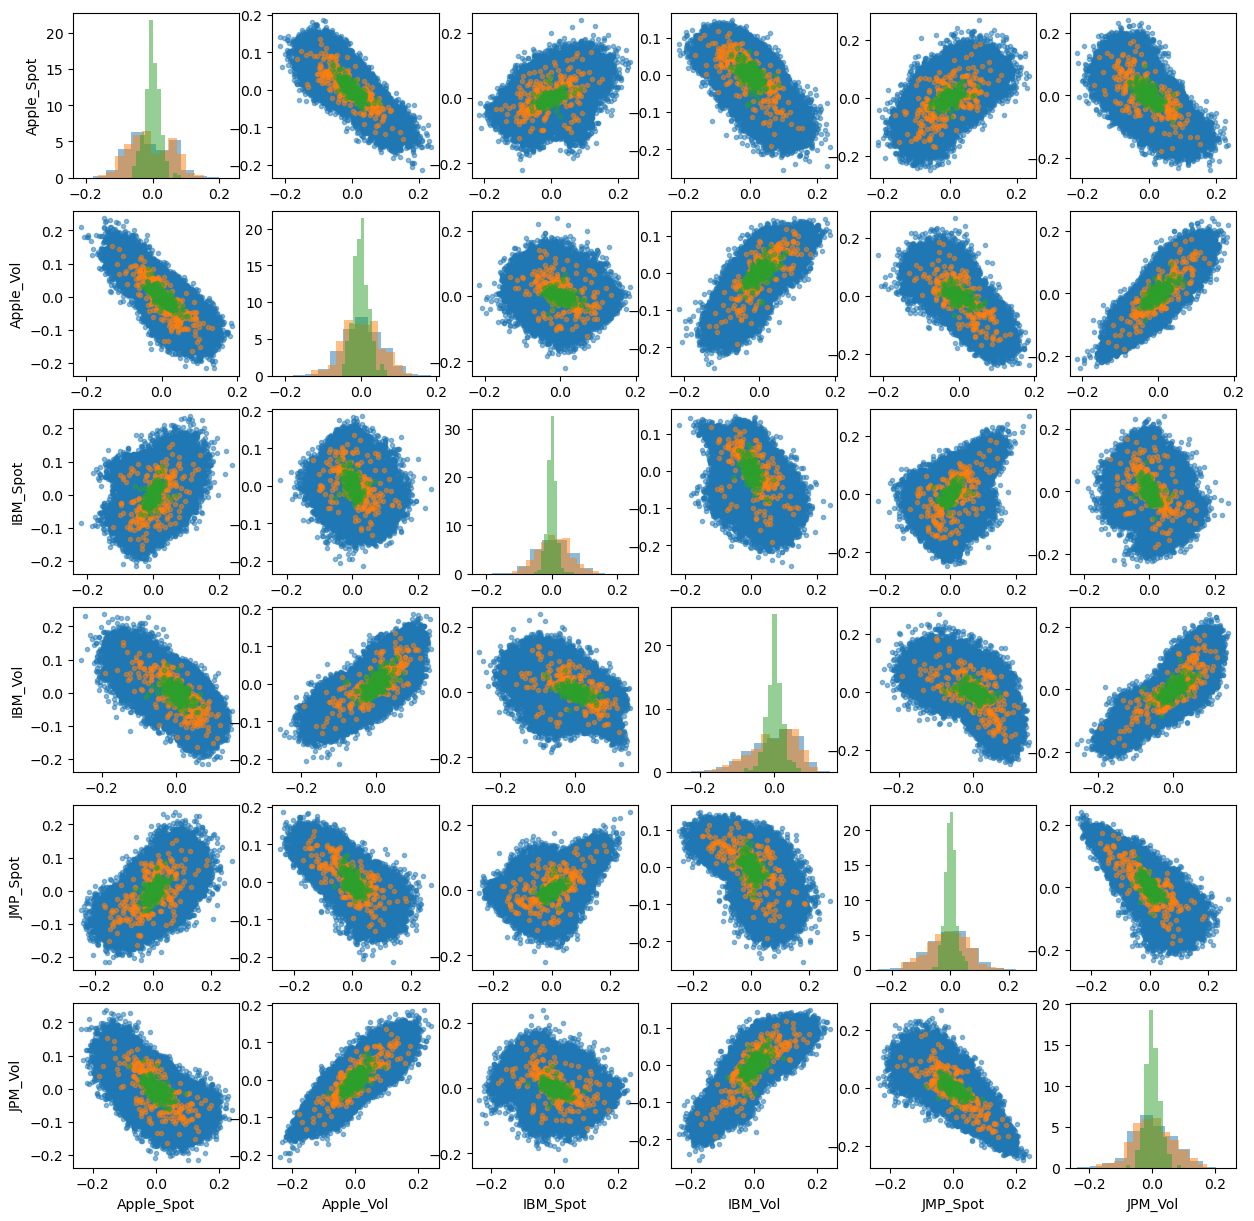

In [13]:
num_sims = 2**16 + 2**14

np.random.seed(5678)

sim_schocks = shuffle(GM.sample(num_sims)[0])

Miscellanea.plot_schocks(6,[sim_schocks,hist_schocks.values,hist_schocks_daily.values],hist_schocks.columns,12)     


### Simulate schocks from $t^+$ to $T$

In [14]:
TTM = 3.0
rfr = 0.01  

S_A_0, S_B_0, S_C_0 = 1.0, 1.0, 1.0

vol_A, vol_B, vol_C  = 0.2, 0.3, 0.15

K_A, K_B, K_C = 1.0, 1.0, 1.0

K = 1.0

correlations = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]

base_scenario = np.array([S_A_0, vol_A, S_B_0, vol_B, S_C_0, vol_C])

sim_scenarios = tf.constant(base_scenario * np.exp(sim_schocks))

hist_var_scenarios = base_scenario * np.exp(hist_schocks)

hist_var_scenarios_daily = base_scenario * np.exp(hist_schocks_daily)


chol = cholesky(correlations)

brow_ind =  np.sqrt(TTM) * np.random.normal(loc = 0.0, scale = 1.0, size = (num_sims, 3))

brow_correl = np.matmul(brow_ind, chol.T)


with tf.GradientTape() as tape:

  tape.watch(sim_scenarios)

  Spots_T = sim_scenarios[:,[0,2,4]]*tf.exp((rfr - 0.5 * sim_scenarios[:,[1,3,5]]**2)*TTM + sim_scenarios[:,[1,3,5]]* brow_correl)
  strikes = [K_A, K_B, K_C]
  payoff = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)

  
sens = tape.gradient(payoff, sim_scenarios)



### <span style="color:red">-----------------Train Models (beware of the options)---------------.</span>

In [ ]:
train_range = np.arange(0,2**16)
train_range_reduced = np.arange(0,2**14)
test_range = np.arange(2**16,num_sims)

valid_data = dict()

valid_data['X_val'] = sim_scenarios.numpy()[test_range]
valid_data['y_val'] = payoff.numpy()[test_range]
valid_data['dydX_val'] = sens.numpy()[test_range]
valid_data['patience'] = 5

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 4]

# epochs = 20
epochs = 500
batch_size = 32


# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
PATH_MODELS = 'MODELS/NO_EARLY/'
# PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'


####################### Use either train_range or train_range_reduced #######################


# If no early stopping
# ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,
#               sim_scenarios.numpy()[train_range], payoff.numpy()[train_range],
#               sens.numpy()[train_range], epochs, batch_size)

# If early stopping
ModelHandlers.TrainSetOfModels(PATH_MODELS,alphas,cells_layer,num_hidden_layers,
              sim_scenarios.numpy()[train_range_reduced], payoff.numpy()[train_range_reduced],
              sens.numpy()[train_range_reduced], epochs, batch_size, valid_data)


### Compute closed form formulas for different scenarios (inc base)

In [15]:
closed_form = Option_formulas.BasketOptionVectorized(3, sim_scenarios[:,[0,2,4]].numpy(), [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  sim_scenarios[:,[1,3,5]].numpy(), np.array(correlations),
                  TTM, True) 

closed_form_daily = Option_formulas.BasketOptionVectorized(3, hist_var_scenarios_daily.values[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  hist_var_scenarios_daily.values[:,[1,3,5]], np.array(correlations),
                  TTM, True) 

closed_form_10d = Option_formulas.BasketOptionVectorized(3, hist_var_scenarios.values[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  hist_var_scenarios.values[:,[1,3,5]], np.array(correlations),
                  TTM, True) 

closed_form_base = Option_formulas.BasketOptionVectorized(3, base_scenario.reshape(1,-1)[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  base_scenario.reshape(1,-1)[:,[1,3,5]], np.array(correlations),
                  TTM, True) 



### Load saved models and compute their metrics

In [16]:
# PATH_MODELS = 'MODELS/RED_SIMS_NO_EARLY/'
# PATH_MODELS = 'MODELS/EARLY/'
# PATH_MODELS = 'MODELS/NO_EARLY/'
PATH_MODELS = 'MODELS/RED_SIMS_EARLY/'

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layers = [1, 2, 4]

train_range = np.arange(0,2**16)
train_range_reduced = np.arange(0,2**14)
test_range = np.arange(2**16,num_sims)

test_scenarios = []

test_scenarios += [{'scenario_name': 'base', 'scenario': base_scenario.reshape(1,-1), 'closed_formula': closed_form_base}]
test_scenarios += [{'scenario_name': '1d', 'scenario': hist_var_scenarios_daily, 'closed_formula': closed_form_daily}]
test_scenarios += [{'scenario_name': '10d', 'scenario': hist_var_scenarios, 'closed_formula': closed_form_10d}]



models = ModelHandlers.load_set_of_models_and_compute_metrics(PATH_MODELS, alphas, cells_layer, num_hidden_layers, 
            sim_scenarios.numpy()[train_range], payoff.numpy()[train_range], 
            sim_scenarios.numpy()[test_range], payoff.numpy()[test_range],
            closed_form[train_range], closed_form[test_range], test_scenarios)



### Compute bayes error

In [17]:
bayes_error_train = mean_squared_error(closed_form[train_range], payoff.numpy()[train_range])
bayes_error_cv = mean_squared_error(closed_form[test_range], payoff.numpy()[test_range])


print(bayes_error_train, bayes_error_cv)


0.05003964712699788 0.050435471091832634


### Obtain best model according to CV MSE

In [18]:
mse_list = []
mse_keys = []

for key in models:

  mse_keys += [key]
  mse_list += [models[key]['mse_cv']]   


print('Best model:')

models[mse_keys[np.argmin(mse_list)]]

Best model:


{'model_name': 'alpha_10.0_cells_128_hidden_2',
 'model_params': {'alpha': 10.0, 'cells': 128, 'hidden': 2},
 'model': <Deep_learning_models.Diff_learning_scaler at 0x23340669e48>,
 'mse_train': 0.050043206326183295,
 'mse_cv': 0.05043502104777223,
 'spearman_train': SpearmanrResult(correlation=0.999354223209258, pvalue=0.0),
 'spearman_cv': SpearmanrResult(correlation=0.9993546946119356, pvalue=0.0),
 'ks_train': KstestResult(statistic=0.0324554443359375, pvalue=2.0150134352150386e-30),
 'ks_cv': KstestResult(statistic=0.03533935546875, pvalue=2.524973471036484e-09),
 'spearman_1d': SpearmanrResult(correlation=0.9970322124763823, pvalue=3.4274676912258866e-278),
 'ks_1d': KstestResult(statistic=0.068, pvalue=0.6109101078019121),
 'spearman_10d': SpearmanrResult(correlation=0.999288052062057, pvalue=0.0),
 'ks_10d': KstestResult(statistic=0.052, pvalue=0.8888778031778077)}

### Plot model metrics

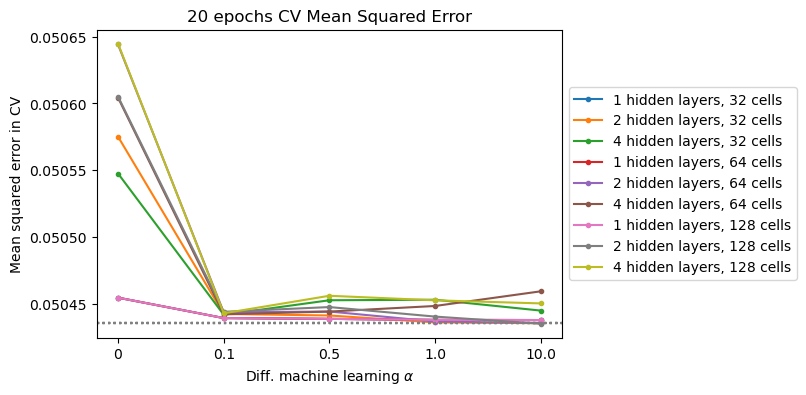

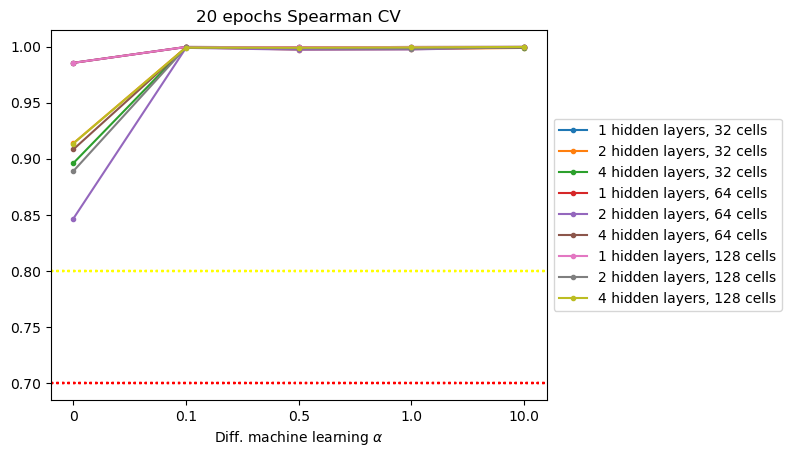

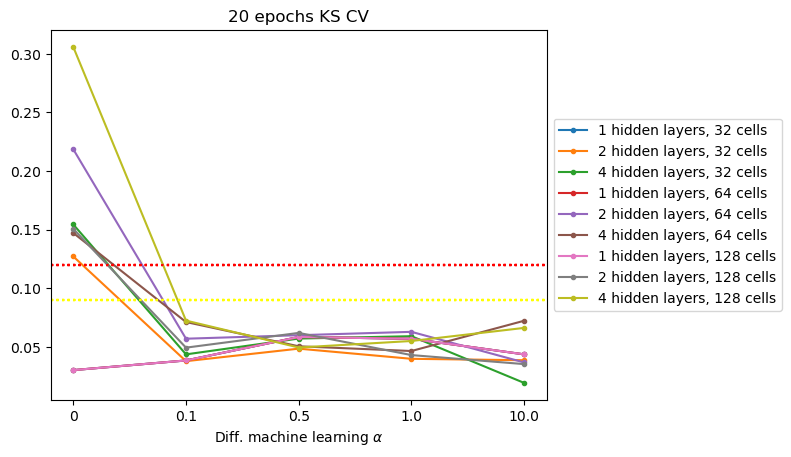

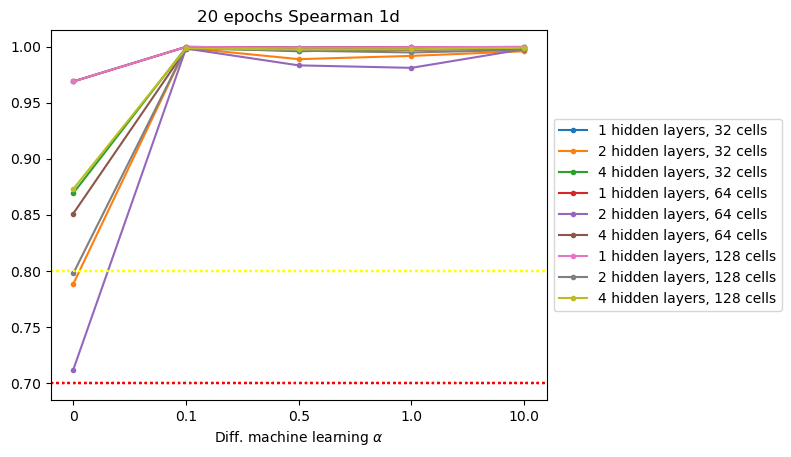

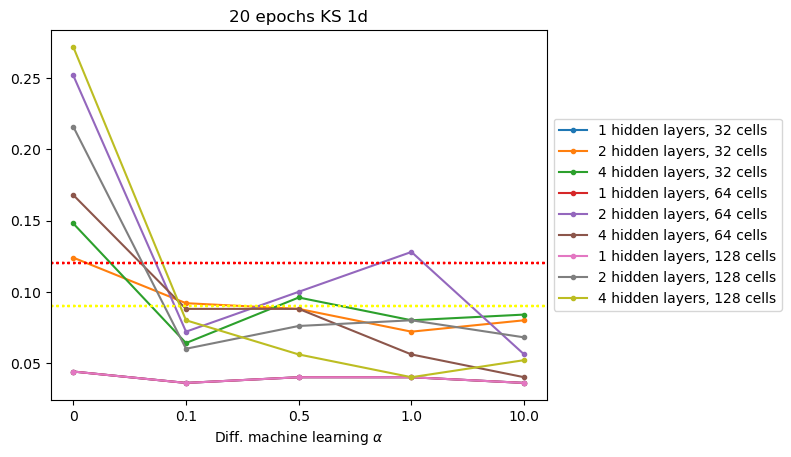

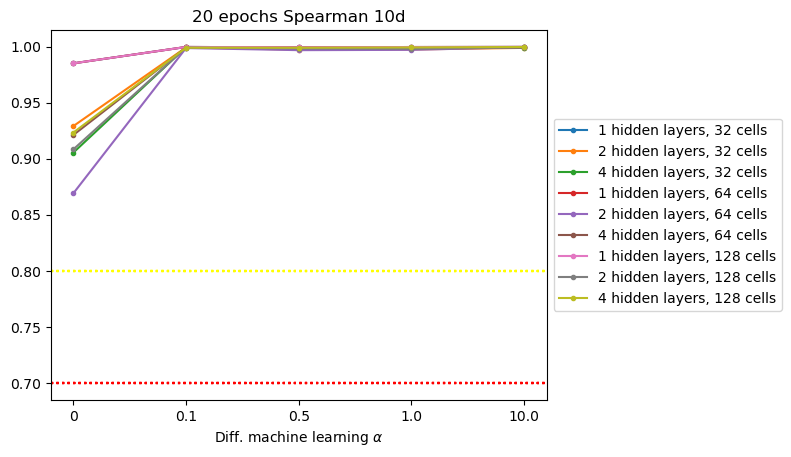

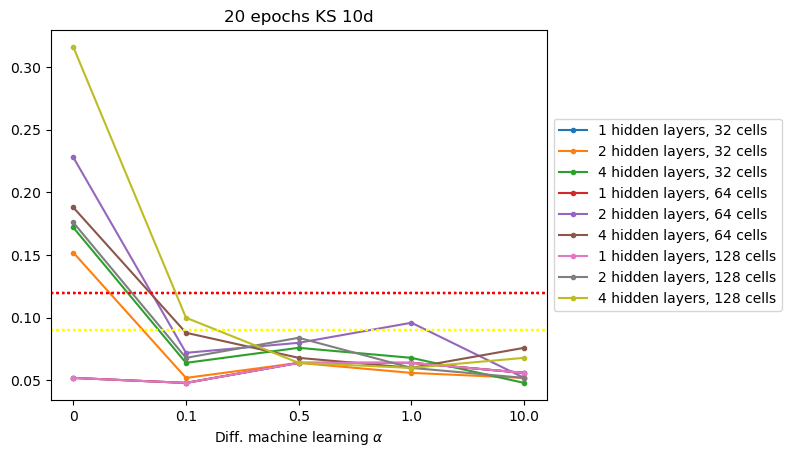

<Figure size 640x480 with 0 Axes>

In [19]:
test_scenario_names = [t['scenario_name'] for t in test_scenarios][1:] 

chart_name = '20 epochs '

ModelHandlers.plot_model_results(models, alphas, cells_layer, num_hidden_layers, test_scenario_names, bayes_error_cv,chart_name, PATH_FIGS)

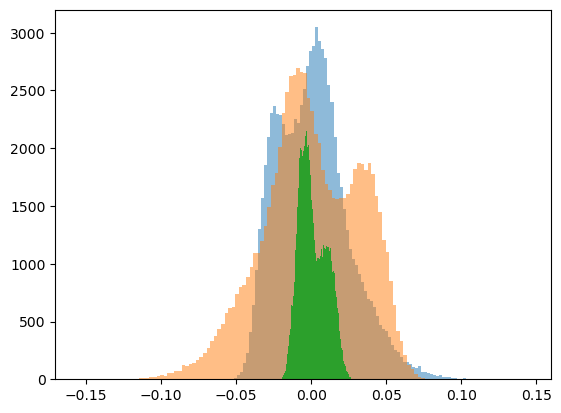

In [325]:
TTM_Hedge = 3.0



call_A = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,0], K_A, TTM_Hedge, rfr, 0.0, MktData[:,1], True)
Fut_A = lambda MktData: Option_formulas.FutureTF(MktData[:,0], K_A, TTM_Hedge, rfr, 0.0)

call_B = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,2], K_B, TTM, rfr, 0.0, MktData[:,3], True)
Fut_B = lambda MktData: Option_formulas.FutureTF(MktData[:,2], K_B, TTM_Hedge, rfr, 0.0)

call_C = lambda MktData: Option_formulas.BlackScholesTF(MktData[:,4], K_C, TTM_Hedge, rfr, 0.0, MktData[:,5], True)
Fut_C = lambda MktData: Option_formulas.FutureTF(MktData[:,4], K_C, TTM_Hedge, rfr, 0.0)

exot = lambda MktData: Option_formulas.BasketOptionVectorized(3, MktData[:,[0,2,4]], [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  MktData[:,[1,3,5]], np.array(correlations),
                  TTM, True) 

basket_elements = [Fut_A, call_A, Fut_B, call_B, Fut_C, call_C]

my_basket = Option Basket(basket_elements, exot)

my_basket.compute_hedge(base_scenario)


plt.hist(exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), bins = 100, alpha = 0.5)

plt.hist(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario), bins=100, alpha = 0.5);


plt.hist((exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy())
         +(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario)), bins = 100);



In [324]:
class Basket:
    
    def __init__(self, basket_elements, exotic):
        """
        Constructor for Basket class.
        
        Args:
        - basket_elements (list of functions): List of functions that calculate the value of each basket element.
        - exotic (function): Function that calculates the value of the exotic option.
        """
        self.basket_elements = basket_elements
        self.exotic = exotic
        self.hedge_computed = False  # flag variable to track if the hedge has been computed
    
    def compute_hedge(self, base_scenario):
        """
        Computes the hedge weights for the basket and sets them as an attribute of the object.
        
        Args:
        - base_scenario (ndarray): 1D array representing the base scenario for the computation of the hedge.
        """
        base_scenario_tensor = tf.constant(base_scenario.reshape(1,-1))

        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(base_scenario_tensor)
            
            basket_calc = [b(base_scenario_tensor) for b in self.basket_elements]
            exotic_calc = self.exotic(base_scenario_tensor) 

        jac = np.concatenate([tape.gradient(b,base_scenario_tensor).numpy() for b in basket_calc], axis = 0)
        
        grad = tape.gradient(exotic_calc, base_scenario_tensor).numpy().T
        
        self.weights = -np.matmul(np.linalg.pinv(jac),grad).T
        self.hedge_computed = True  # set the flag variable to True
    
    def value_basket(self, scenario):
        """
        Calculates the value of the basket for a given scenario.
        
        Args:
        - scenario (ndarray): 1D or 2D array representing the scenario(s) for which to calculate the basket value.
        
        Returns:
        - ndarray: 1D array representing the basket value(s) for the given scenario(s).
        """
        if not self.hedge_computed:  # check if the hedge has been computed
            raise ValueError("Hedge has not been computed yet")
        
        if scenario.ndim == 1:
            scenario = scenario.reshape(1,-1)
            
        return np.sum(self.weights*np.concatenate([b(scenario).reshape(-1,1) for b in self.basket_elements], axis = 1), axis = 1)


In [287]:
class Basket:
    
    def __init__(self, basket_elements, exotic):
        
        self.basket_elements = basket_elements
        self.exotic = exotic
    
    def compute_hedge(self, base_scenario):
        
        base_scenario_tensor = tf.constant(base_scenario.reshape(1,-1))

        with tf.GradientTape(persistent=True) as tape:
            
            tape.watch(base_scenario_tensor)
            
            basket_calc = [b(base_scenario_tensor) for b in self.basket_elements]
            exotic_calc = self.exotic(base_scenario_tensor) 

        jac = np.concatenate([tape.gradient(b,base_scenario_tensor).numpy() for b in basket_calc], axis = 0)
        
        grad = tape.gradient(exotic_calc, base_scenario_tensor).numpy().T
        
        self.weights = -np.matmul(np.linalg.pinv(jac),grad).T
        
    def value_basket(self, scenario):
        
        if scenario.ndim == 1:
            scenario = scenario.reshape(1,-1)
            
        return np.sum(self.weights*np.concatenate([b(scenario).reshape(-1,1) for b in self.basket_elements], axis = 1), axis = 1)                                                      
    
    
                                                         
                                                        

In [317]:
aaa= (exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy())+(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario))

In [318]:
aaa.shape

(81920,)

In [311]:
(my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario)).shape


(81920,)

In [274]:
my_basket.value_basket(sim_scenarios)

array([-0.06583799, -0.03427868, -0.04790213, ..., -0.07491966,
       -0.06702642, -0.05009731])

In [146]:
sim_scenarios.shape

TensorShape([81920, 6])

In [233]:
call_A(sim_scenarios)

<tf.Tensor: shape=(81920,), dtype=float64, numpy=
array([0.18837703, 0.13224752, 0.17144885, ..., 0.17334214, 0.19805038,
       0.16056111])>

In [278]:
base_scenario

array([1.  , 0.2 , 1.  , 0.3 , 1.  , 0.15])

In [279]:
base_scenario

array([1.  , 0.2 , 1.  , 0.3 , 1.  , 0.15])

In [280]:
exot(base_scenario.reshape(1,-1))

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.12734442])>

In [306]:
exot(hist_var_scenarios_daily.values)

<tf.Tensor: shape=(250,), dtype=float64, numpy=
array([0.12734442, 0.13383229, 0.12786576, 0.12890209, 0.12601427,
       0.12568292, 0.13974415, 0.13530645, 0.12089189, 0.12221646,
       0.1287376 , 0.12925761, 0.12501768, 0.13024735, 0.12592666,
       0.11622965, 0.12734442, 0.11764051, 0.12068274, 0.12306032,
       0.12211793, 0.1300099 , 0.13394612, 0.12622984, 0.12215973,
       0.14067754, 0.13146144, 0.13015448, 0.12821781, 0.12681828,
       0.12915509, 0.12677746, 0.1342148 , 0.12874652, 0.12029581,
       0.12174992, 0.12290211, 0.1318357 , 0.12496739, 0.11662829,
       0.1268824 , 0.12734442, 0.12398252, 0.11832967, 0.12466013,
       0.13512917, 0.11927693, 0.1208424 , 0.13698707, 0.12962315,
       0.12295318, 0.1179595 , 0.12255522, 0.1393833 , 0.11709977,
       0.11978852, 0.12614023, 0.13615044, 0.14055357, 0.12978205,
       0.12971691, 0.12664726, 0.13440954, 0.12551067, 0.13298098,
       0.13283941, 0.1270833 , 0.1303379 , 0.12707323, 0.11675505,
       0.12520

In [304]:
hist_var_scenarios_daily

,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2021-12-24,1.000000,0.200000,1.000000,0.300000,1.000000,0.150000
2021-12-27,1.022975,0.198165,1.007579,0.300847,1.005723,0.149023
2021-12-28,0.994233,0.200631,1.007674,0.296597,1.003035,0.149953
2021-12-29,1.000502,0.199184,1.005429,0.306143,0.999496,0.148993
2021-12-30,0.993422,0.197844,1.004199,0.298621,0.999495,0.148343
...,...,...,...,...,...,...
2022-12-02,0.996629,0.199349,0.996715,0.300845,0.992073,0.149483
2022-12-05,0.992017,0.203779,0.991525,0.301588,0.971959,0.154301
2022-12-06,0.974630,0.203038,1.000611,0.303693,1.001675,0.152403


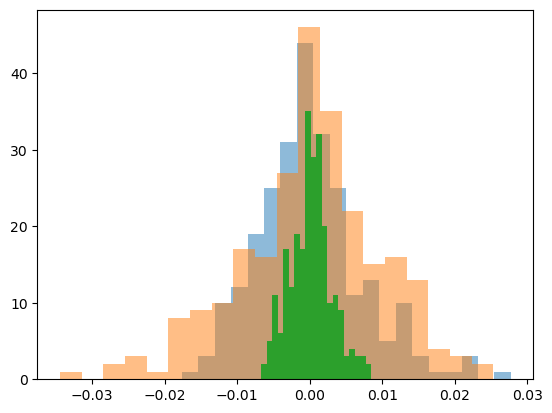

In [322]:
plt.hist(exot(hist_var_scenarios_daily.values).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), bins = 20, alpha = 0.5)

plt.hist(my_basket.value_basket(hist_var_scenarios_daily.values)-my_basket.value_basket(base_scenario), bins=20, alpha = 0.5);


plt.hist((exot(hist_var_scenarios_daily.values).numpy()-exot(base_scenario.reshape(1,-1)).numpy())
         +(my_basket.value_basket(hist_var_scenarios_daily.values)-my_basket.value_basket(base_scenario)), bins = 20);

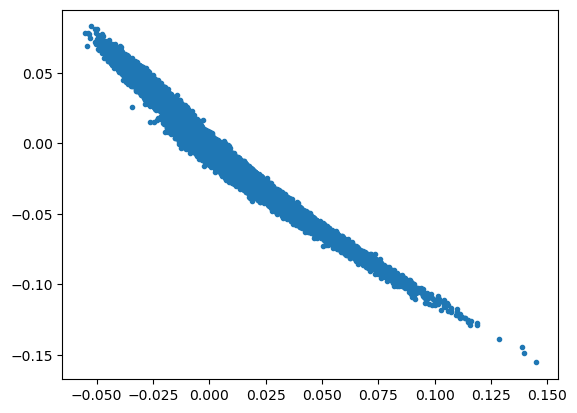

In [323]:
plt.plot(exot(sim_scenarios).numpy()-exot(base_scenario.reshape(1,-1)).numpy(), my_basket.value_basket(sim_scenarios)-my_basket.value_basket(base_scenario), '.')